In [1]:
%matplotlib inline
%env PYTORCH_ENABLE_MPS_FALLBACK=1
# import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# import videoUtility
import numpy.linalg as la
import scipy.io

import sys

# import sparsify
import sparsify_PyTorch
import utility

import torch

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [2]:
# Load video data from a npz file
# mat = scipy.io.loadmat('../Data/IMAGES.mat')
mat = scipy.io.loadmat('./Data/IMAGES_Vanhateren.mat')
vm = mat['IMAGES'].astype('float32')

np.shape(vm)

(512, 512, 35)

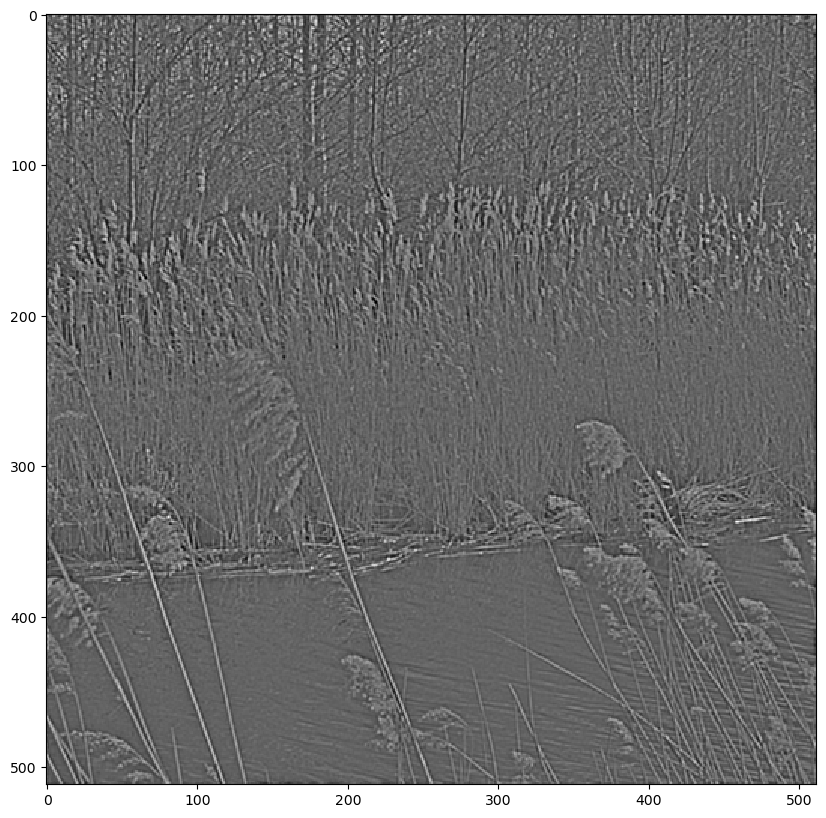

In [3]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
utility.imshow(vm[:,:,4],ax=ax)

In [4]:
device = torch.device('mps')
# Now let's start to learn sparse coding basis
# Effective dimensionality is about 200, let's make it 20 times overcomplete.
# Layer1 sparse coding initialization

xdim = 16 #Patch size
ydim = 16 #Patch size
BASIS1_NUM = 2048
BASIS1_SIZE = [xdim*ydim, BASIS1_NUM]
BATCH_SIZE = 100

basis1 = torch.randn(BASIS1_SIZE, device=device)
basis1 = basis1.div_(basis1.norm(2,0))

lambd = 1.0
STEPS = 3000000

ACT_HISTORY_LEN = 300
HessianDiag = torch.zeros(BASIS1_NUM, device=device)
ActL1 = torch.zeros(BASIS1_NUM, device=device)
signalEnergy = 0.
noiseEnergy = 0.

edgeBuff = 5
spRange_x = vm.shape[0] - xdim - edgeBuff * 2
spRange_y = vm.shape[1] - ydim - edgeBuff * 2
spRange_t = vm.shape[2]
I = np.zeros([xdim*ydim,BATCH_SIZE]).astype('float32')
totalSteps1 = 0

In [5]:
for i in range(totalSteps1,STEPS):
    for j in range(BATCH_SIZE):
        xIdx = np.floor(np.random.rand()*spRange_x + edgeBuff).astype(int)
        yIdx = np.floor(np.random.rand()*spRange_y + edgeBuff).astype(int)
        sIdx = np.floor(np.random.rand()*spRange_t).astype(int)
        I[:,j] = vm[xIdx:xIdx+xdim,yIdx:yIdx+ydim,sIdx].reshape([xdim*ydim])
    I_tensor = torch.from_numpy(I).to(device)
    
    #Sparse Coefficients Inference by ISTA
    #For positive-only codes, use ISTA
    #For positive-negative codes, use ISTA_PN 
    ahat, Res = sparsify_PyTorch.ISTA(I_tensor, basis1, 0.08, 1000)
    #ahat, Res = sparsify_PyTorch.ISTA(I_tensor, basis1, 0.03, 1000)
    
    #Statistics Collection
    ActL1 = ActL1.mul((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + ahat.abs().mean(1)/ACT_HISTORY_LEN
    HessianDiag = HessianDiag.mul((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(ahat,2).mean(1)/ACT_HISTORY_LEN
    
    signalEnergy = signalEnergy*((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(I_tensor,2).sum()/ACT_HISTORY_LEN
    noiseEnergy = noiseEnergy*((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(Res,2).sum()/ACT_HISTORY_LEN
    snr = signalEnergy/noiseEnergy
    
    #Dictionary Update
    totalSteps1 = totalSteps1 + 1
    basis1 = sparsify_PyTorch.quadraticBasisUpdate(basis1, Res, ahat, 0.001, HessianDiag, 0.005)
    
    #Print Information
    if i % 100 == 0:
        print(totalSteps1, snr, HessianDiag.min(), HessianDiag.max(), ActL1.min(), ActL1.max(), ActL1.sum())

/Users/derek/Desktop/SMT_YubeiChen/Sparse-Coding/sparsify_PyTorch.py:104: UserWarning: The operator 'aten::_linalg_eigh.eigenvalues' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1704987089515/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  L = torch.max(torch.linalg.eigh(torch.mm(basis,basis.t()))[0])


1 tensor(237.8293, device='mps:0') tensor(3.3412e-07, device='mps:0') tensor(0.0014, device='mps:0') tensor(3.6915e-06, device='mps:0') tensor(0.0008, device='mps:0') tensor(0.4343, device='mps:0')
101 tensor(323.9671, device='mps:0') tensor(0.0054, device='mps:0') tensor(0.0182, device='mps:0') tensor(0.0089, device='mps:0') tensor(0.0217, device='mps:0') tensor(27.8077, device='mps:0')
201 tensor(327.8482, device='mps:0') tensor(0.0104, device='mps:0') tensor(0.0278, device='mps:0') tensor(0.0163, device='mps:0') tensor(0.0351, device='mps:0') tensor(45.3497, device='mps:0')


KeyboardInterrupt: 

In [ ]:
reload(utility)

<module 'utility' from '../PythonVer/utility.py'>

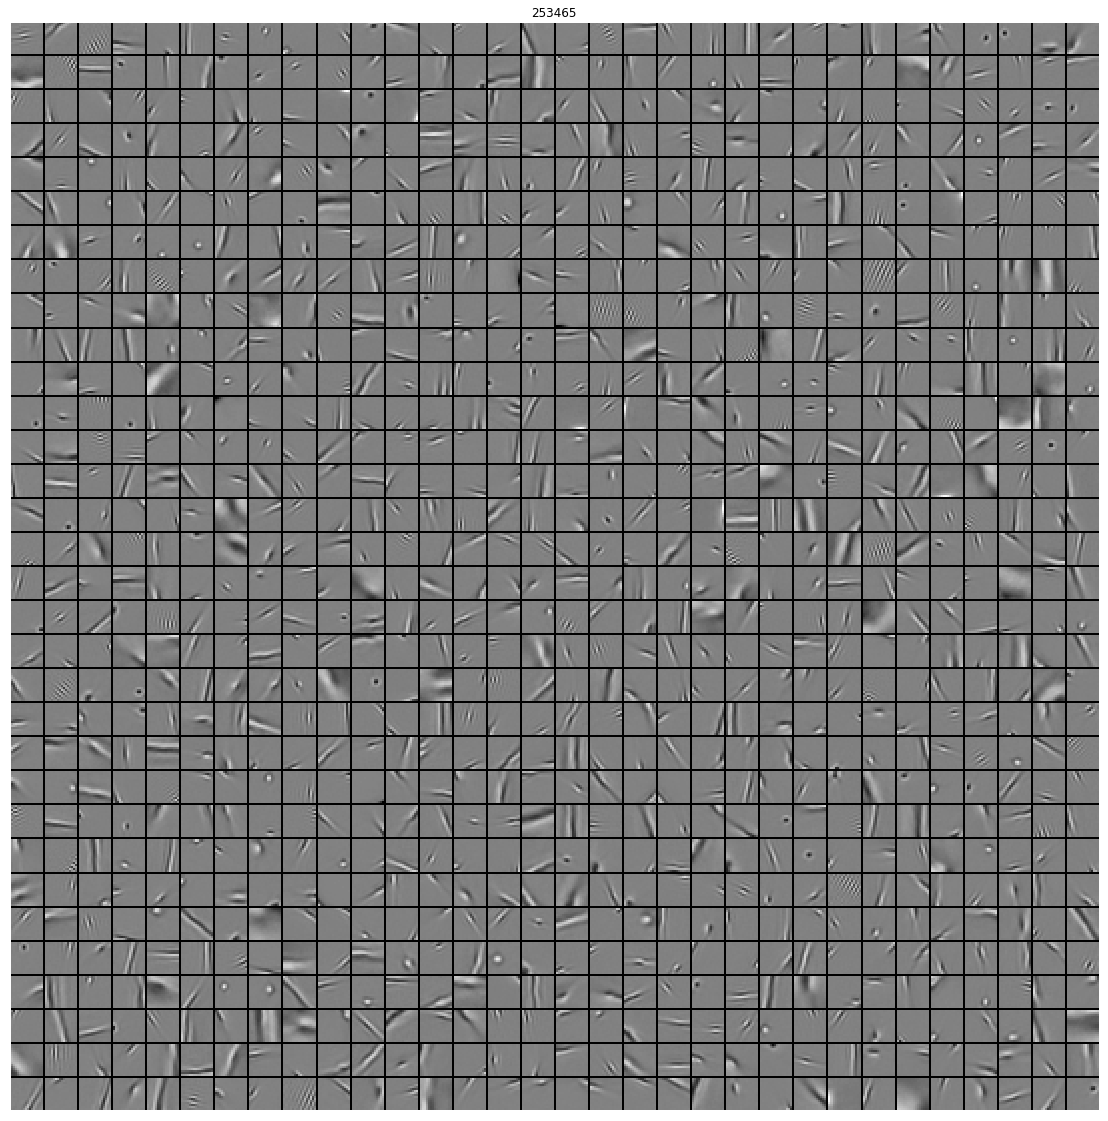

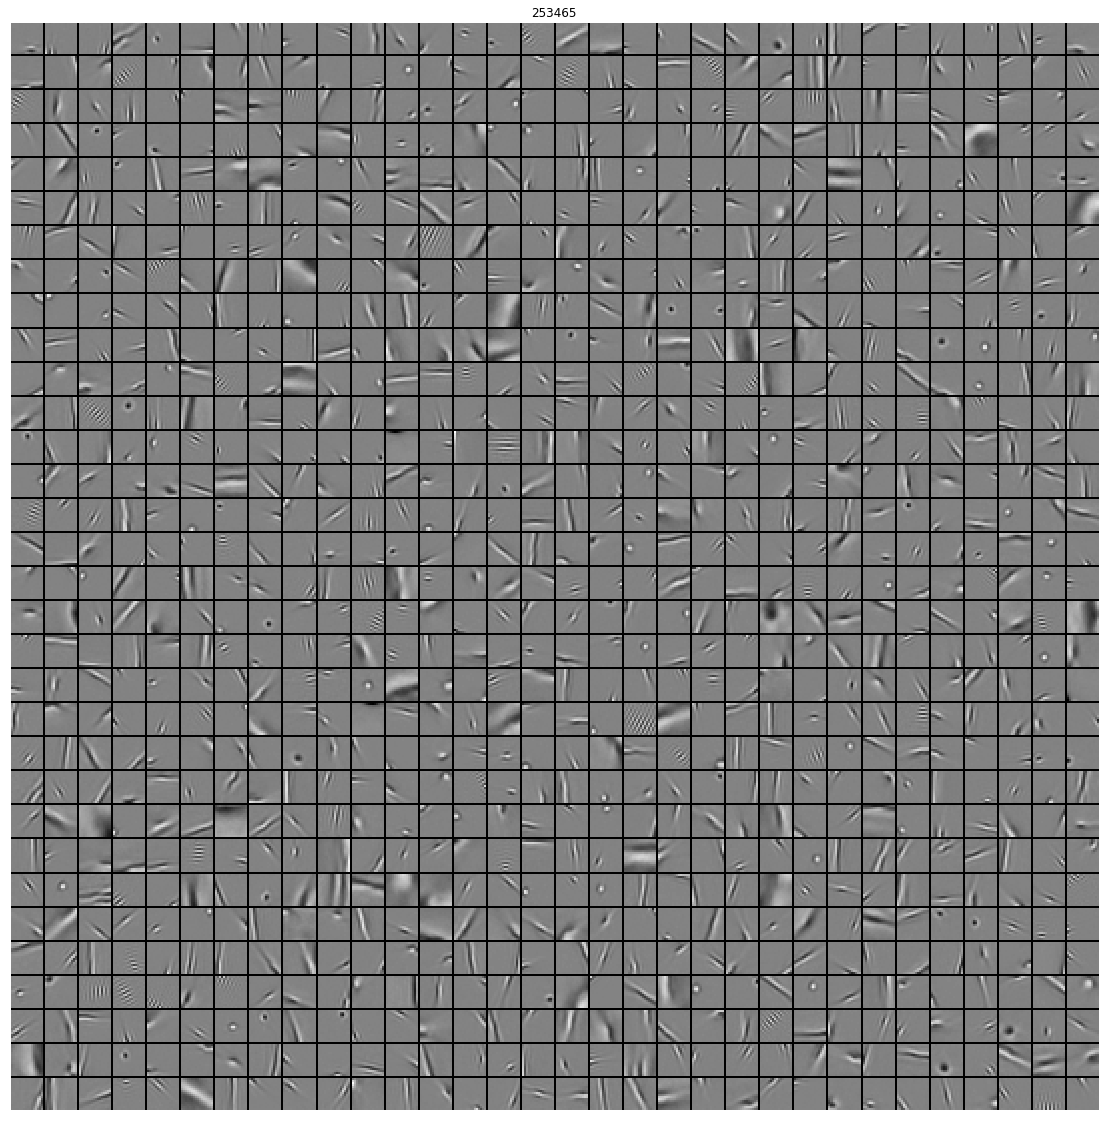

In [ ]:
#Dictionary Visualization
basis1_host = basis1.cpu().numpy()
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
utility.displayVecArry(basis1_host,32,32,ax=ax,title=i,equal_contrast=True) #Visualize first 1024 Dictionary Elements
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
utility.displayVecArry(basis1_host[:,1024:],32,32,ax=ax,title=i,equal_contrast=True) #Visualize first 1024 Dictionary Elements

In [ ]:
np.savez("basis1_IMAGES_Vanhateren_10x.npz", basis1 = basis1_host)